# Term Deposit Marketing
- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: Feb 27, 2023

## Table of Content


## Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

## Data Wrangling and Preprocessing

First let's load and take a look at the dataset.

In [2]:
df = pd.read_csv('./data/term-deposit-marketing-2020.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


It appears that there is no `Null` values in the dataset. However, we do notice that the dataset is a mix of categorical features and numerical features. We would need to convert the categorical features into numerical representations so that we can apply statistical modeling.

### Processing Categorical Features

In [5]:
def show_categorical_col(df):
    category_features = df.select_dtypes(['object']).columns.values
    print(f'There are {len(category_features)} categorical features in the dataset.')
    print(f'The categorical features are {category_features}')
    display(df[category_features].head())
    return category_features
category_features = show_categorical_col(df)

There are 9 categorical features in the dataset.
The categorical features are ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'y']


,job,marital,education,default,housing,loan,contact,month,y
0,management,married,tertiary,no,yes,no,unknown,may,no
1,technician,single,secondary,no,yes,no,unknown,may,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,no
4,unknown,single,unknown,no,no,no,unknown,may,no


Now let's examine the individual categorical columns. We will define a function to help us explore a particular column.

In [6]:
def explore_categorical(df, col):
    # Display information of a column if it is categorical
    if df[col].dtypes == 'object':
        unique_cat = len(df[col].unique())
        print(f'Column Name: {col} \n{20*"-"}')
        print(f'Feature {col} has {unique_cat} unique categories\n')
        print(df[col].value_counts(normalize=True))
        plt.figure(figsize=(10, 1.2*unique_cat))
        sns.countplot(y=col, data=df, order = df[col].value_counts().index, color="#58508d")
        plt.show()
        print()

#### Preprocessing `y` (target variable)

Firstly let's take a look at the target variable `y`.

Column Name: y 
--------------------
Feature y has 2 unique categories

no     0.9276
yes    0.0724
Name: y, dtype: float64


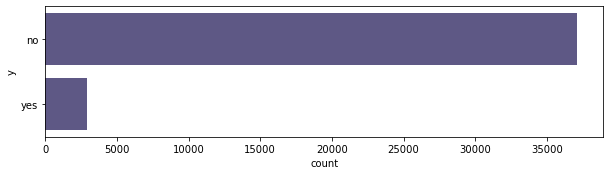

In [7]:
explore_categorical(df, 'y')

92.76% of the customer are not subscribed to a term deposit and only 7.24% of them did. The classes are not balanced and we need to address this issue. Accuracy will unlikely to be a good metric when designing our model and we would need to consider the other metrics for evaluation.

We will map `y` into a binary variable with 0 for no and 1 for yes.

In [8]:
df['y'] = df['y'].map({'no':0, 'yes':1})

#### Preprocessing `job`

Column Name: job 
--------------------
Feature job has 12 unique categories

blue-collar      0.234575
management       0.204150
technician       0.171300
admin            0.112075
services         0.097750
retired          0.035925
self-employed    0.035350
entrepreneur     0.035125
unemployed       0.027600
housemaid        0.027175
student          0.013100
unknown          0.005875
Name: job, dtype: float64


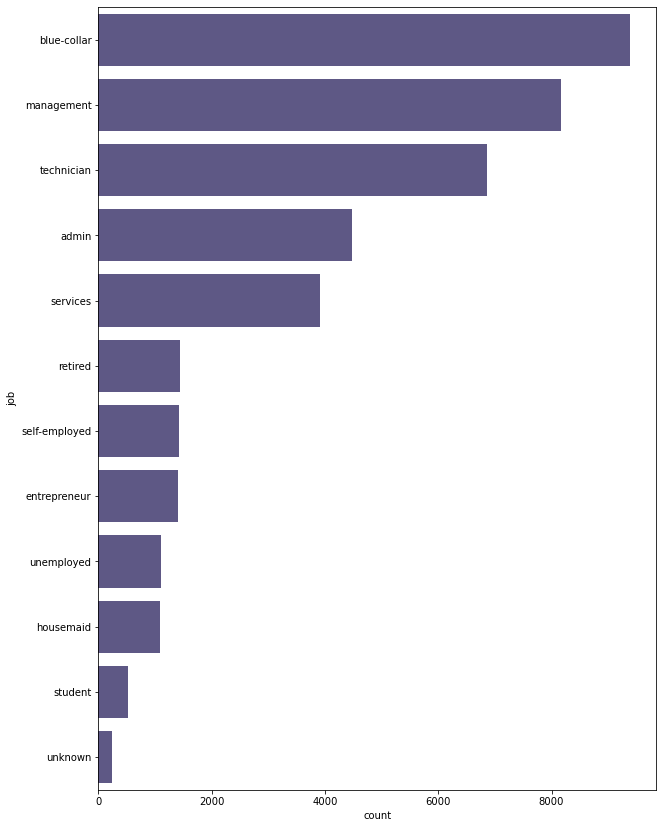

In [9]:
explore_categorical(df, 'job')

The majority of the customers work as `blue-collar`, `management` and `technician`, taking up 23.46%, 20.42 and 17.13% of the total customer base respectively. There are to the lesser extent, `admin` and `services` workers, at 11.2% and 9.78%.

The rest of the job types only accounts for about 18% of the population. The job types with lower population are typically short on deposit funds, which could be explanation of why they do not make up the majority of the business. There are also 0.58% of customers with unknown job types. We can group these job types into one single category called `others`.

In [10]:
job_types = ['blue-collar', 'management', 'technician', 'admin', 'services']
df['job'] = np.where(df['job'].isin(job_types), df['job'], 'others')

#### Preprocessing `marital`

Column Name: marital 
--------------------
Feature marital has 3 unique categories

married     0.609650
single      0.272225
divorced    0.118125
Name: marital, dtype: float64


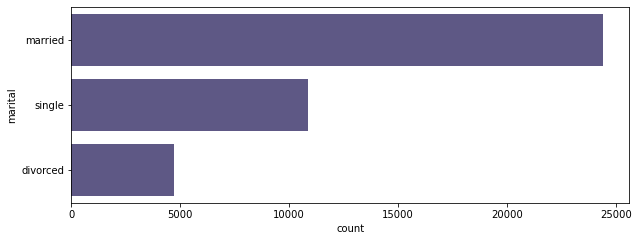

In [11]:
explore_categorical(df, 'marital')

72.8% of the customers are either married or divorced, in comparison to only 27.2% of the customer who are single. This indicates that the majority of the customers are middle-aged or beyond.

#### Preprocessing `education`

Column Name: education 
--------------------
Feature education has 4 unique categories

secondary    0.524825
tertiary     0.280150
primary      0.156750
unknown      0.038275
Name: education, dtype: float64


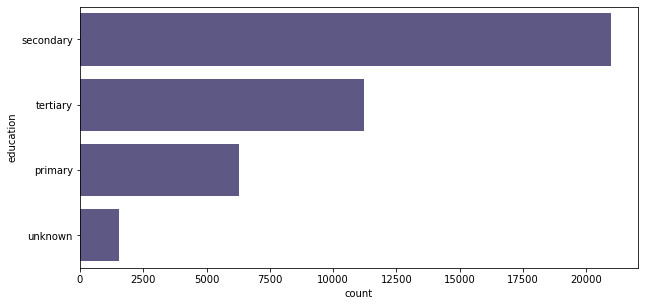

In [12]:
explore_categorical(df, 'education')

52.48% of the customers have completed a secondary education. 28% of the customers have completed post-secondary eduction whereas 15.68% of the customers only have completed a primary education. There are 3.8% of the customers with unknown education background. We can lump these in together with `secondary`.

In [13]:
df.loc[df['education']=='unknown', 'education'] = 'secondary'

#### Preprocessing `default`

Column Name: default 
--------------------
Feature default has 2 unique categories

no     0.979775
yes    0.020225
Name: default, dtype: float64


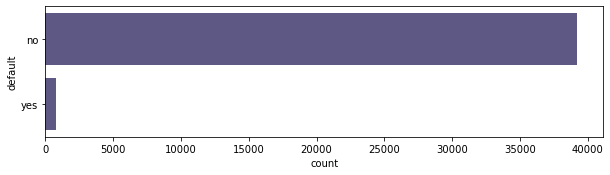

In [14]:
explore_categorical(df, 'default')

The overwhelmingly majority of 98% of the customer do not have credit in default whereas 2% only them do. We might consider dropping this column since the categories are heavily imbalanced.

We should firstly verify that `default` is not contributing a lot to the classification.

In [15]:
df['default'].value_counts()

no     39191
yes      809
Name: default, dtype: int64

In [16]:
df[df['default']=='yes']['y'].value_counts()

0    760
1     49
Name: y, dtype: int64

Out of 809 customers without credit in default, only 49 of them are subscribed to a term deposit, which is similar to the ratio of the class distribution. Therefore, it should be safe to conclude that `default` is not key factor in classifying `y` and can be removed.

In [17]:
df.drop('default', axis=1, inplace=True)

#### Preprocessing `housing` and `loan`

Column Name: housing 
--------------------
Feature housing has 2 unique categories

yes    0.600775
no     0.399225
Name: housing, dtype: float64


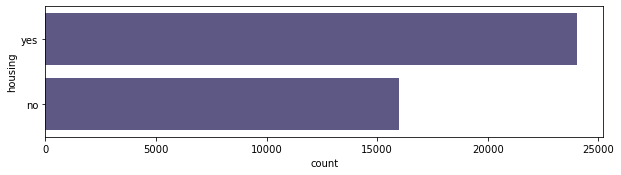

In [18]:
explore_categorical(df, 'housing')

60% of the customers have a housing loan and 40% of them do not.

Column Name: loan 
--------------------
Feature loan has 2 unique categories

no     0.82675
yes    0.17325
Name: loan, dtype: float64


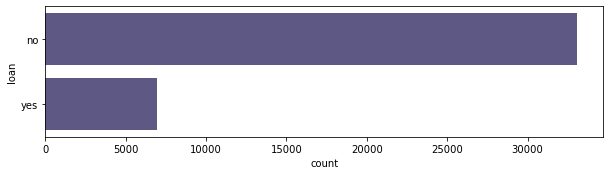

In [19]:
explore_categorical(df, 'loan')

82.7% of the customers do not have a personal loan and 17.3% of them do. The distribution are not similar to the distribution of `housing`.

We will map `housing` and `loan` into a binary variable with 0 for no and 1 for yes.

In [20]:
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})

#### Preprocessing `contact`

Column Name: contact 
--------------------
Feature contact has 3 unique categories

cellular     0.622850
unknown      0.319125
telephone    0.058025
Name: contact, dtype: float64


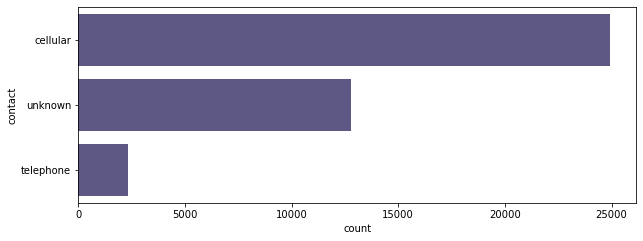

In [21]:
explore_categorical(df, 'contact')

The majority of the customers at 62.3% uses cellular to make communication and only 5.8% of the customers uses telephone. There are 31.9% of customer with unknown communication method. 

We make the argument that it is reasonable to combine `unknown` and `telephone` since the bank does not explicitly know that the customer uses cellular as the communication method. We can store the new information into a column called `use_cellular`

In [22]:
df['use_cellular'] = df['contact'].map({'cellular': 1, 'unknown': 0, 'telephone': 0})
df.drop('contact', axis=1, inplace=True)

#### Preprocessing `month`

Column Name: month 
--------------------
Feature month has 11 unique categories

may    0.338300
jul    0.159500
aug    0.130375
jun    0.118350
nov    0.089950
apr    0.067950
feb    0.057400
jan    0.029400
mar    0.006450
oct    0.002000
dec    0.000325
Name: month, dtype: float64


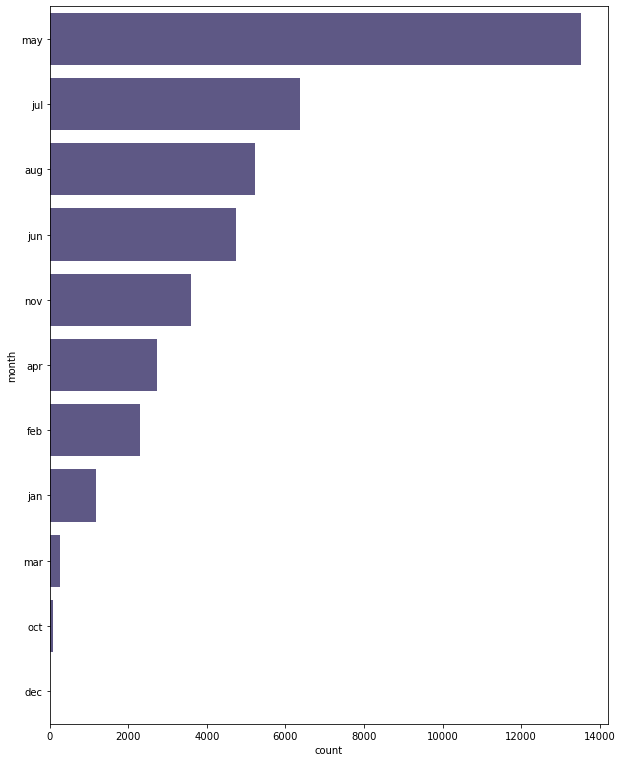

In [23]:
explore_categorical(df, 'month')

33.8% of the customers made the last contact in May and there are rarely any customer last contacted in October and December, at 0.2% and 0.03% respectively. Maybe there existed some customer searching campaign during the early to mid summer.

One option is to group the month into quarters.

In [24]:
df['quarter'] = pd.to_datetime(df['month'], format='%b').dt.quarter

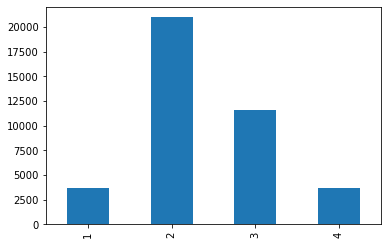

In [25]:
df['quarter'].value_counts().sort_index().plot(kind='bar')
plt.show()

Interesting to note above, very little contact happened during Q1 and Q4. The majority of the contacts were made in the second quarter with a sharp decline in Q3.

Also, since majority of the last contacts happened in May, July, August and June, we could consider these months `heavy_months` and create a binary feature to decide if the last call happened in a heavy month.

In [26]:
heavy_months = ['may', 'jul', 'aug', 'jun']
df['heavy_months'] = 0
df.loc[df['month'].isin(heavy_months), 'heavy_months'] = 1

In [27]:
df.drop('month', axis=1, inplace=True)

After processing all the categorical columns, we can go back to numerical columns.

### Preprocessing Numerical Features

Similar to the categorical columns, we will define a function to help visualize the numerical columns.

In [28]:
def explore_numerical(df, col):
    if df[col].dtypes in ['int', 'float']:
        print(f'Column Name: {col} \n{20*"-"}')
        print(f'minimum value: {df[col].min()}')
        print(f'median value: {df[col].median()}')
        print(f'maximum value: {df[col].max()}')
        print(f'mean value: {df[col].mean()}')
        plt.figure(figsize=(7.5, 7.5))
        sns.boxplot(y=col, data=df, color="#58508d")
        plt.show()
        print()

#### Preprocessing `balance`

Column Name: balance 
--------------------
minimum value: -8019
median value: 407.0
maximum value: 102127
mean value: 1274.27755


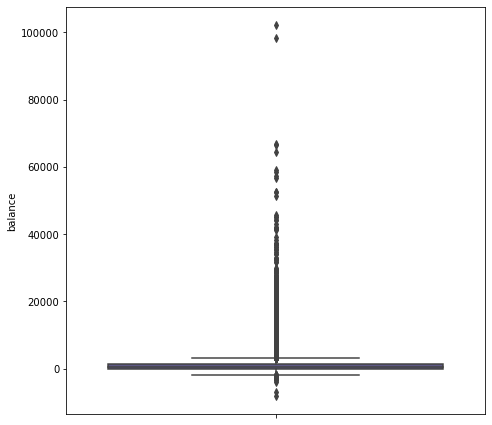

In [29]:
explore_numerical(df, 'balance')

It seems that the majority of the account balance are below 2000 but the highest balance goes up to 102127.

#### Preprocessing `campaign`

Column Name: campaign 
--------------------
minimum value: 1
median value: 2.0
maximum value: 63
mean value: 2.882175


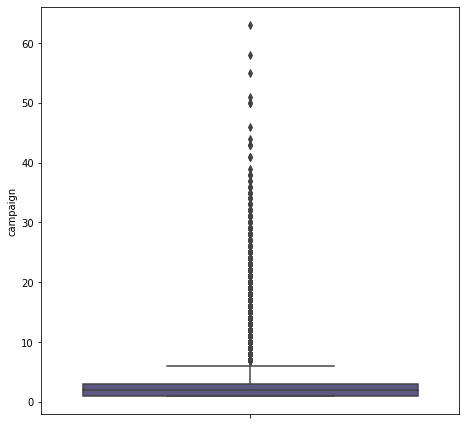

In [30]:
explore_numerical(df, 'campaign')

It appears that over half of the data points belongs in campaign 1 and 2. Let's take a deeper look into the specific distribution of the data.

In [31]:
df['campaign'].value_counts()

1     14718
2     11153
3      4970
4      3297
5      1642
6      1228
7       699
8       526
9       318
10      262
11      197
12      154
13      131
14       93
15       83
16       78
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: campaign, dtype: int64

The campaign 1 and 2 makes up the majority of the data. We categorize the values as `1`, `2` and `others` as the values are not statistically semantic.

In [32]:
df['campaign'] = np.where(df['campaign'].isin([1,2]), df['campaign'].apply(lambda x: str(x)), 'others')

#### Preprocessing `day`

Column Name: day 
--------------------
minimum value: 1
median value: 17.0
maximum value: 31
mean value: 16.017225


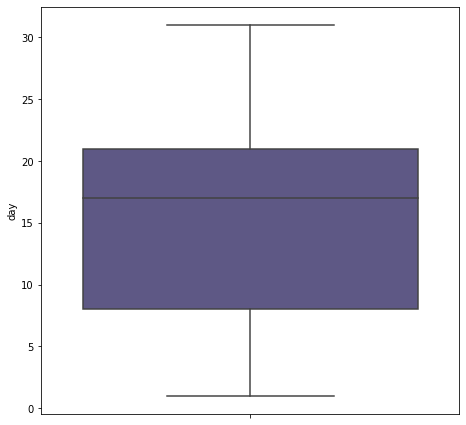

In [33]:
explore_numerical(df, 'day')

Since the `day` value is unlikely to contribute to the classification, we will drop it from the dataset.

In [34]:
df.drop('day', axis=1, inplace=True)

### Create dummy df

Now that we are done preprocessing the columns, we can transfer the df into a dummy df.

In [35]:
dummy_df = pd.get_dummies(df)

In [36]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  40000 non-null  int64
 1   balance              40000 non-null  int64
 2   housing              40000 non-null  int64
 3   loan                 40000 non-null  int64
 4   duration             40000 non-null  int64
 5   y                    40000 non-null  int64
 6   use_cellular         40000 non-null  int64
 7   quarter              40000 non-null  int64
 8   heavy_months         40000 non-null  int64
 9   job_admin            40000 non-null  uint8
 10  job_blue-collar      40000 non-null  uint8
 11  job_management       40000 non-null  uint8
 12  job_others           40000 non-null  uint8
 13  job_services         40000 non-null  uint8
 14  job_technician       40000 non-null  uint8
 15  marital_divorced     40000 non-null  uint8
 16  marital_married      4

Now that we have the dummy df constructed, let's examine if there is any columns highly correlated with each other.

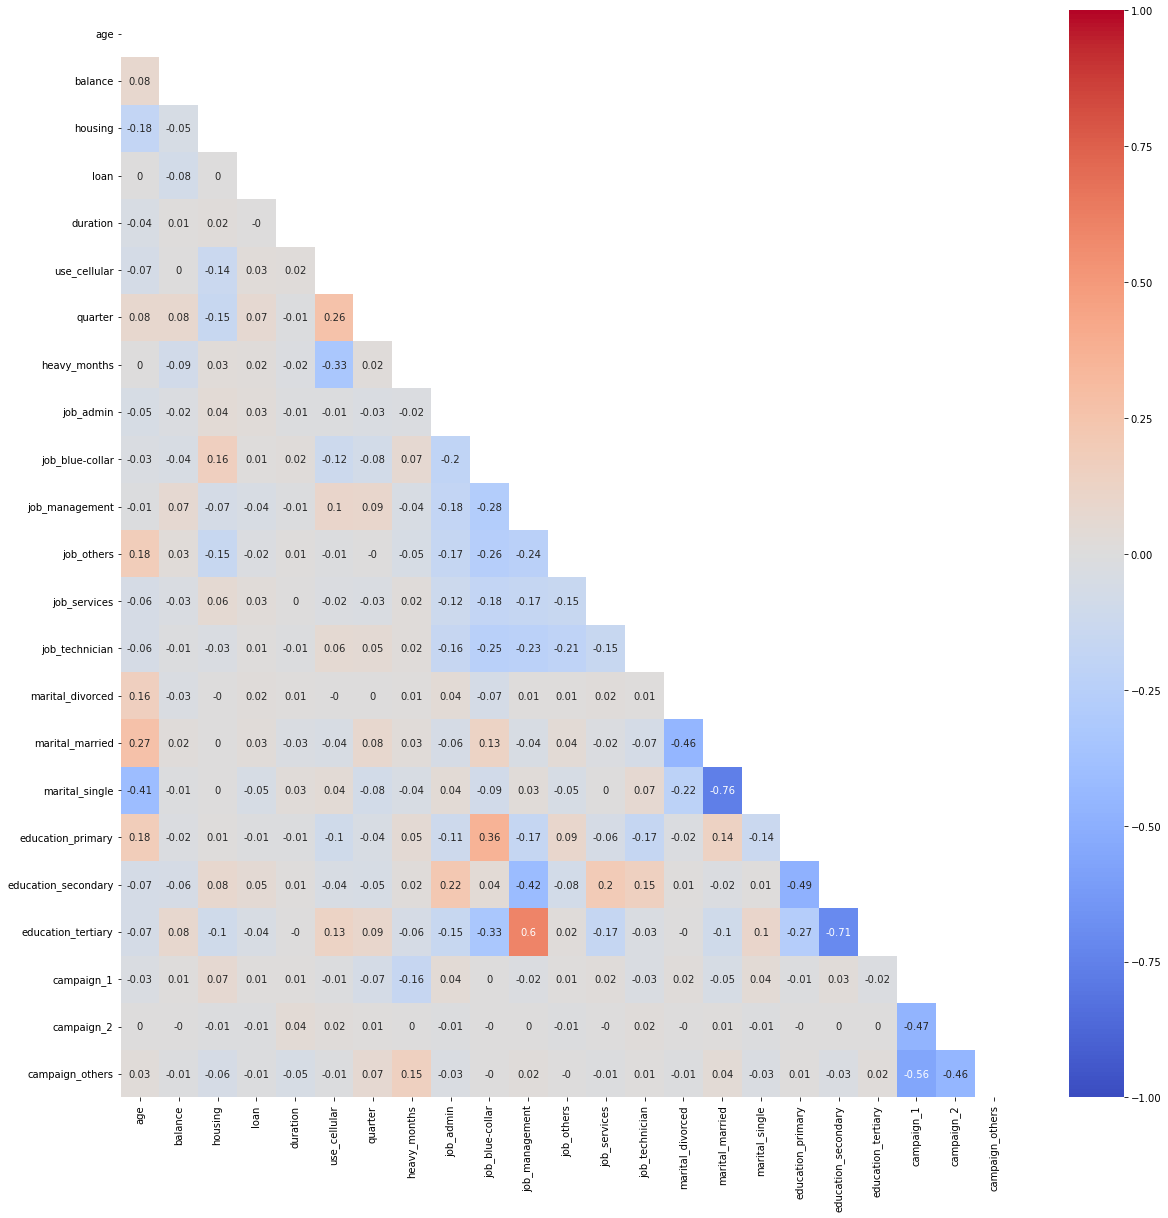

In [37]:
def visualize_correlation(X):

    # calculate all the correlations between each of the independent variables
    corr_df = X.corr()

    # mask
    mask = np.triu(corr_df)


    # heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_df.round(2), vmax=1, vmin=-1, center=0, annot=True, mask=mask, cmap='coolwarm')
visualize_correlation(dummy_df.drop('y', axis=1))

For the purpose of this analysis, we will use a correlation threshold of 0.8 to decide if two features are highly correlated. From the correlation heatmap above, we can see that `marital_single`, `marital_married` has a correlation of -0.76, and `education_teritary`, `education_secondary` has a correlation of -0.71. These two pairs has relatively high correlation but since they are still below our threshold by a little, we will keep them in the dataset.

### Saving the processed dataset

We will save the processed dataset as `tdm_preprocessed.csv` under the `data` folder.

In [38]:
dummy_df.to_csv('./data/tdm_preprocessed.csv')

## Modeling

Now that we are done with preprocessing the data, we can now move on to fitting some models to the data and get a intuition of ideal model. We might still consider removing some features if we find any features are not as important in the backward selection process.

### Balancing the classes

As we saw in the data wrangling section, 92.76% of our customers are not subscribed to a term deposit and belong to class 0, whereas only 7.24% of customers belong to class 1. This indicates strong imbalance between the classes and it will affect the performance of our models and our evaluation of them. We will combine the following methods to tackle the class imbalance issue:
- Downsampling the majority class 0
- Upsampling the minority class 1
- Consider F1 score instead of accuracy as the main evaluation metric.

In [39]:
# Preparing the training and testing dataset
from sklearn.model_selection import train_test_split

X = dummy_df.drop(columns="y")
y = dummy_df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [40]:
from sklearn.utils import resample

# Downsampling class 0
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 0].shape[0]//3, 
                                        random_state=123)
print('Number of class 0 examples after:', X_downsampled.shape[0])

# Upsampling class 1
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                        y_train[y_train == 1], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0]*3, 
                                        random_state=123)
print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combining the data
X_train_bal = np.vstack((X_downsampled, X_upsampled))
y_train_bal = np.hstack((y_downsampled, y_upsampled))

print('Total number of examples: ', X_train_bal.shape[0])

Number of class 0 examples before: 25954
Number of class 0 examples after: 8651
Number of class 1 examples before: 2046
Number of class 1 examples after: 6138
Total number of examples:  14789


With a mix of downsampling and upsampling technique, we are able to generate a more balanced training dataset consists of 14789 examples, with 8651 entries of class 0 and 6138 entries of class 1.

### Normalization

To make sure the distance based models like KNN would have a reasonable performance on the data, we will normalize the data before fitting the models.

In [41]:
from sklearn.preprocessing import StandardScaler

# Normalizing the balanced training data
ss = StandardScaler()
X_train_bal = ss.fit_transform(X_train_bal)
X_test = ss.transform(X_test)

### Model Selection

Now we can start fitting some models.

In [49]:
model_candidates = [LogisticRegression(random_state=22), SVC(random_state=22), 
                    RandomForestClassifier(max_depth=10, random_state=22),
                    KNeighborsClassifier(), 
                    AdaBoostClassifier(random_state=22), 
                    xgb.XGBClassifier(max_depth=3, random_state=22)]
model_names = ['logreg', 'SVC', 'KNN', 'RF', 'Ada', 'XGB']

for i, model in enumerate(model_candidates):
    model.fit(X_train_bal, y_train_bal)
    print(f'{model_names[i]} training accuracy: {model.score(X_train_bal, y_train_bal)}')
    print(f'{model_names[i]} testing accuracy: {model.score(X_test, y_test)}')
    print()

logreg training accuracy: 0.8269659882344986
logreg testing accuracy: 0.8821666666666667

SVC training accuracy: 0.8938400162282778
SVC testing accuracy: 0.8754166666666666

KNN training accuracy: 0.9258232470079113
KNN testing accuracy: 0.8879166666666667

RF training accuracy: 0.911353032659409
RF testing accuracy: 0.8165

Ada training accuracy: 0.8394752856853066
Ada testing accuracy: 0.87875

XGB training accuracy: 0.894516194468862
XGB testing accuracy: 0.8750833333333333



All of our models performed reasonably well on the training and testing set with beyond 80% accuracy. But considering the strong imbalance in the testing set, we would have to pick the model that have the best performance on the minority class in the test set, which is class 1. We will check out the confusion matrix and the classification report to gain more insight and choose the best model.

In [53]:
def show_confusion_matrix_and_report(model_name, model, X_train, y_train, X_test, y_test):
    print_line = '\n----------------------------------\n'
    
    print(f"Confusion matrices: {model_name}", print_line)

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Model on the original data
    plot_confusion_matrix(model, X_train, y_train, ax=axes[0])
    axes[0].set_title('Confusion Matrix: Training')

    # Model on the upsampled data
    plot_confusion_matrix(model, X_test, y_test, ax=axes[1])
    axes[1].set_title('Confusion Matrix: Testing')
    
    plt.show()
    
    model_pred_train = model.predict(X_train)
    model_pred_test = model.predict(X_test)
    
    report_train = classification_report(y_train, model_pred_train)
    report_test = classification_report(y_test, model_pred_test)
    
    print("\nTraining data classification report:", print_line, report_train)
    print("\nTesting data classification report:", print_line, report_test)

Confusion matrices: logreg 
----------------------------------



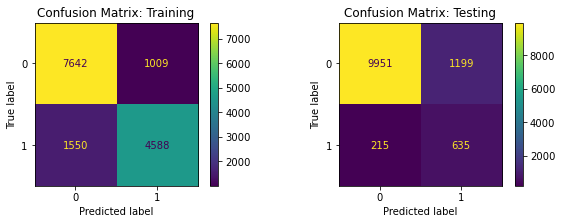


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      8651
           1       0.82      0.75      0.78      6138

    accuracy                           0.83     14789
   macro avg       0.83      0.82      0.82     14789
weighted avg       0.83      0.83      0.83     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     11150
           1       0.35      0.75      0.47       850

    accuracy                           0.88     12000
   macro avg       0.66      0.82      0.70     12000
weighted avg       0.93      0.88      0.90     12000

Confusion matrices: SVC 
----------------------------------



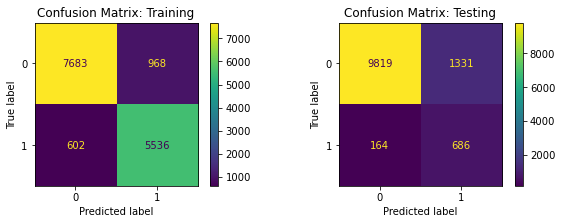


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      8651
           1       0.85      0.90      0.88      6138

    accuracy                           0.89     14789
   macro avg       0.89      0.90      0.89     14789
weighted avg       0.90      0.89      0.89     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     11150
           1       0.34      0.81      0.48       850

    accuracy                           0.88     12000
   macro avg       0.66      0.84      0.70     12000
weighted avg       0.94      0.88      0.90     12000

Confusion matrices: KNN 
----------------------------------



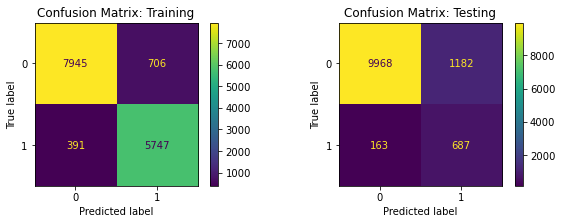


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      8651
           1       0.89      0.94      0.91      6138

    accuracy                           0.93     14789
   macro avg       0.92      0.93      0.92     14789
weighted avg       0.93      0.93      0.93     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.89      0.94     11150
           1       0.37      0.81      0.51       850

    accuracy                           0.89     12000
   macro avg       0.68      0.85      0.72     12000
weighted avg       0.94      0.89      0.91     12000

Confusion matrices: RF 
----------------------------------



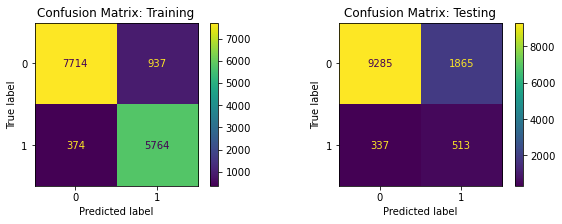


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      8651
           1       0.86      0.94      0.90      6138

    accuracy                           0.91     14789
   macro avg       0.91      0.92      0.91     14789
weighted avg       0.91      0.91      0.91     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.96      0.83      0.89     11150
           1       0.22      0.60      0.32       850

    accuracy                           0.82     12000
   macro avg       0.59      0.72      0.61     12000
weighted avg       0.91      0.82      0.85     12000

Confusion matrices: Ada 
----------------------------------



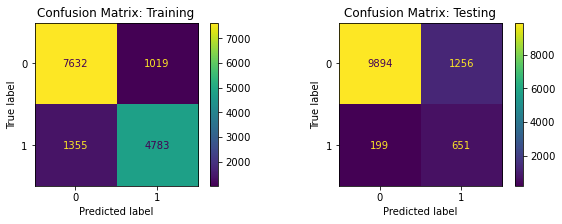


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      8651
           1       0.82      0.78      0.80      6138

    accuracy                           0.84     14789
   macro avg       0.84      0.83      0.83     14789
weighted avg       0.84      0.84      0.84     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     11150
           1       0.34      0.77      0.47       850

    accuracy                           0.88     12000
   macro avg       0.66      0.83      0.70     12000
weighted avg       0.94      0.88      0.90     12000

Confusion matrices: XGB 
----------------------------------



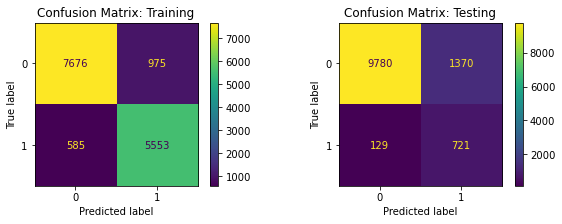


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      8651
           1       0.85      0.90      0.88      6138

    accuracy                           0.89     14789
   macro avg       0.89      0.90      0.89     14789
weighted avg       0.90      0.89      0.89     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     11150
           1       0.34      0.85      0.49       850

    accuracy                           0.88     12000
   macro avg       0.67      0.86      0.71     12000
weighted avg       0.94      0.88      0.90     12000



In [54]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

for i, model in enumerate(model_candidates):
    show_confusion_matrix_and_report(model_names[i], model, 
                                    X_train_bal, y_train_bal, X_test, y_test)

Out of all the models, KNN has a f1-score for class 1 in the testing data that is slightly better than the others at 0.51. It is followed by XGBoost which has a f1-score of 0.49.

We will see if we could further improve these two models by hyperparameter tuning.

### Hyperparameter tuning

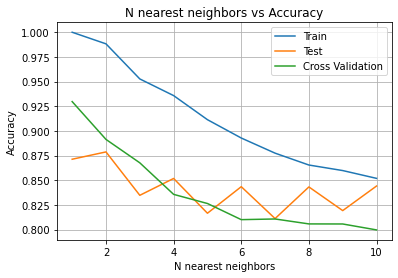

In [61]:
from sklearn.model_selection import cross_val_score

# tuning KNN
ns = np.arange(1,11)
train_scores = []
test_scores = []
cv_scores = []

for n in ns:
    knn = KNeighborsClassifier(n_neighbors=n)
    cv_scores.append(np.mean(cross_val_score(knn, X_train_bal, y_train_bal, cv=5)))
    knn.fit(X_train_bal, y_train_bal)
    train_scores.append(knn.score(X_train_bal, y_train_bal))
    test_scores.append(knn.score(X_test, y_test))
    
plt.figure()
plt.plot(ns, train_scores, label='Train')
plt.plot(ns, test_scores, label='Test')
plt.plot(ns, cv_scores, label='Cross Validation')
plt.title('KNN N nearest neighbors vs Accuracy')
plt.xlabel('N nearest neighbors')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

By increasing the number of nearest neighbors, we gradually reduce the overfitting and with `n_neighbors` set to 10, the training and testing accuracy become very close. So we will finalize our KNN model with `n_neighbors=10`. 

Let's take a look at its confusion matrix and classification report.

Confusion matrices: knn(n_neighbors=10) 
----------------------------------



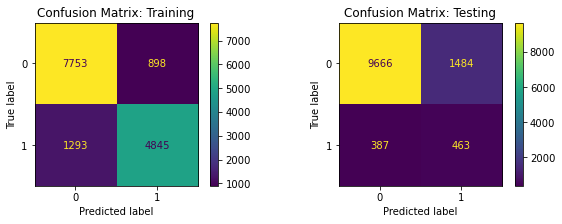


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      8651
           1       0.84      0.79      0.82      6138

    accuracy                           0.85     14789
   macro avg       0.85      0.84      0.85     14789
weighted avg       0.85      0.85      0.85     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.96      0.87      0.91     11150
           1       0.24      0.54      0.33       850

    accuracy                           0.84     12000
   macro avg       0.60      0.71      0.62     12000
weighted avg       0.91      0.84      0.87     12000



In [66]:
knn_final = KNeighborsClassifier(n_neighbors=10)
knn_final.fit(X_train_bal, y_train_bal)

show_confusion_matrix_and_report('knn(n_neighbors=10)', knn_final, X_train_bal, y_train_bal,
                                X_test, y_test)

The final KNN model has 84% testing accuracy on the test set and a f1-score of 0.33. The model has a much higher recall for class 1 of 0.54 than precision of 0.24 which is desirable since there is only 7% of positive class in the testing set and we are trying to increase the model's ability of identifying them.

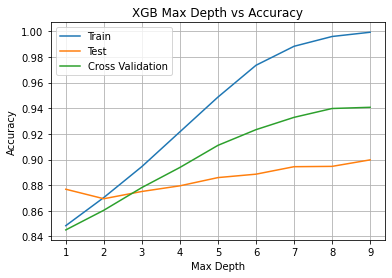

In [64]:
# Tuning XGBoost max_depth
depths = np.arange(1,10)
train_scores = []
test_scores = []
cv_scores = []

for depth in depths:
    xgb_model = xgb.XGBClassifier(max_depth=depth)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train_bal, y_train_bal, cv=5)))
    xgb_model.fit(X_train_bal, y_train_bal)
    train_scores.append(xgb_model.score(X_train_bal, y_train_bal))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.figure()
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.plot(depths, cv_scores, label='Cross Validation')
plt.title('XGB Max Depth vs Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

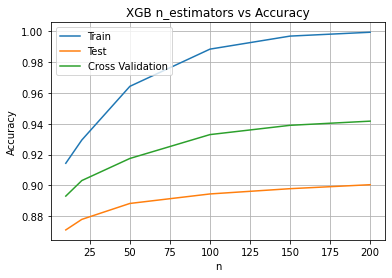

In [68]:
# Tuning XGBoost max_depth
ns = [10, 20, 50, 100, 150, 200]
train_scores = []
test_scores = []
cv_scores = []

for n in ns:
    xgb_model = xgb.XGBClassifier(n_estimators=n, max_depth=7)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train_bal, y_train_bal, cv=5)))
    xgb_model.fit(X_train_bal, y_train_bal)
    train_scores.append(xgb_model.score(X_train_bal, y_train_bal))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.figure()
plt.plot(ns, train_scores, label='Train')
plt.plot(ns, test_scores, label='Test')
plt.plot(ns, cv_scores, label='Cross Validation')
plt.title('XGB n_estimators vs Accuracy')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

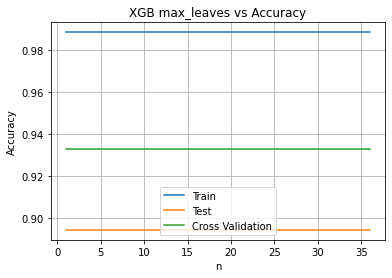

In [69]:
# Tuning XGBoost max_leaf
n_leaves = np.arange(1,41,5)
train_scores = []
test_scores = []
cv_scores = []

for n in n_leaves:
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=7, max_leaves=n)
    cv_scores.append(np.mean(cross_val_score(xgb_model, X_train_bal, y_train_bal, cv=5)))
    xgb_model.fit(X_train_bal, y_train_bal)
    train_scores.append(xgb_model.score(X_train_bal, y_train_bal))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.figure()
plt.plot(n_leaves, train_scores, label='Train')
plt.plot(n_leaves, test_scores, label='Test')
plt.plot(n_leaves, cv_scores, label='Cross Validation')
plt.title('XGB max_leaves vs Accuracy')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

Seems like our XGBoost model performs the best with `n_estimators=100` and `max_depths=7`. The `max_leaves` parameter did not make any difference. We will create the final xgb model and checkout its confusion matrix and classification report.

[00:11:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

Confusion matrices: XGB final model 
----------------------------------



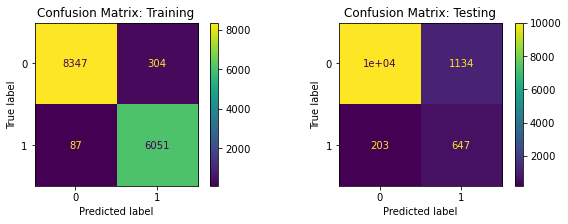


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      8651
           1       0.95      0.99      0.97      6138

    accuracy                           0.97     14789
   macro avg       0.97      0.98      0.97     14789
weighted avg       0.97      0.97      0.97     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.90      0.94     11150
           1       0.36      0.76      0.49       850

    accuracy                           0.89     12000
   macro avg       0.67      0.83      0.71     12000
weighted avg       0.94      0.89      0.91     12000



In [70]:
xgb_final = xgb.XGBClassifier(n_estimators=100, max_depths=7)
xgb_final.fit(X_train_bal, y_train_bal)
show_confusion_matrix_and_report('XGB final model', xgb_final, X_train_bal, y_train_bal,
                                X_test, y_test)

Our final XGBoost model has 97% training accuracy and 89% testing accuracy and f1-score of 0.49 for class 1. It performed better than our KNN model. Thought we have different class distribution for the training and testing set, we could argue that the model is overfitting the training data.

### Feature importance

Now that we have a final working XGB model, we can leverage the `feature importance` of such tree based models and eliminate features that are less important.

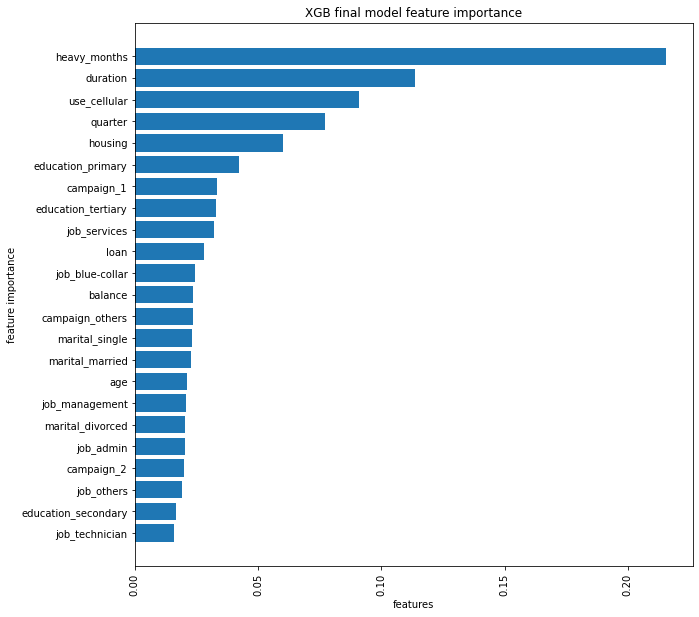

In [108]:
# Construct a importance df
importance_df = pd.DataFrame(xgb_final.feature_importances_, index=X.columns, columns=['Importance'])
importance_df.sort_values(by='Importance', inplace=True)

# Plot feature importance
plt.figure(figsize=(10,10))
plt.barh(importance_df.index, importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('features')
plt.ylabel('feature importance')
plt.title('XGB final model feature importance')
plt.show()

As we mentioned above, the model is somewhat overfitting the training data. We could reduce overfitting by only keeping the most important features. Here we will only keep the features with importance over 0.05.

In [120]:
# Get the feature names
selected_features = importance_df[importance_df['Importance'] > 0.05].index

# construct a df for training and testing sets
X_train_bal_df = pd.DataFrame(X_train_bal, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [124]:
# only keep the selected features
X_train_bal_df = X_train_bal_df[selected_features]
X_test_df = X_test_df[selected_features]

[01:59:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depths" } are not used.

Confusion matrices: 5 feature XGB model 
----------------------------------



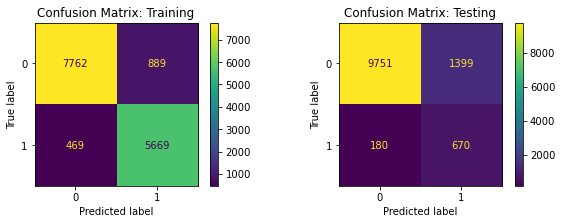


Training data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      8651
           1       0.86      0.92      0.89      6138

    accuracy                           0.91     14789
   macro avg       0.90      0.91      0.91     14789
weighted avg       0.91      0.91      0.91     14789


Testing data classification report: 
----------------------------------
               precision    recall  f1-score   support

           0       0.98      0.87      0.93     11150
           1       0.32      0.79      0.46       850

    accuracy                           0.87     12000
   macro avg       0.65      0.83      0.69     12000
weighted avg       0.94      0.87      0.89     12000



In [125]:
# Retrain a xgb model and see the performance
xgb_5_feature = xgb.XGBClassifier(n_estimators=100, max_depths=7)
xgb_5_feature.fit(X_train_bal_df.values, y_train_bal)
show_confusion_matrix_and_report('5 feature XGB model', xgb_5_feature, X_train_bal_df.values,
                                y_train_bal, X_test_df.values, y_test)

Only using the five most important features, our XGB model has 91% accuracy on the training set and 87% accuracy on the testing set. We significantly improved the overfitting issue. The recall value for class 1 in the testing set improved by 0.03 and the precision dropped by 0.04. This indicates that the less important features are probably more crucial for identifying customers who are not subscribed to a term deposit. 

Assuming we are more interested in finding customers who are subscribed to a term deposit, we should consider the five features selected instead of using the full features.